In [88]:
import tensorflow as tf
import pandas as pd
import os
import sys
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model
from sklearn.model_selection import train_test_split

In [89]:
def word_split(mystring):
    str_split = []
    for tmp in mystring:
        tmp = re.sub('[^a-zA-Z0-9\s]+', '', tmp)
        tmp = tmp.replace('the', '')
        tmp = tmp.split(' ')
        while True:
            if '' not in tmp:
                break
            tmp.remove('')    
        str_split.append(tmp)
    return str_split

In [90]:
GLOVE_DIR = './'
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 100
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [91]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [92]:
all_data = pd.read_csv("train.csv")
data = all_data['Headline']
label = all_data['Label']
my_split = word_split(data)

In [93]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(my_split)
sequences = tokenizer.texts_to_sequences(my_split)
word_index = tokenizer.word_index
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [94]:
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i-1] = embedding_vector

In [102]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [106]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
NUM_LSTM_UNITS = 32
shared_lstm = LSTM(NUM_LSTM_UNITS)
xx = shared_lstm(embedded_sequences)
'''
x = Dense(units=32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units=8, activation='relu')(x)
x = Dropout(0.2)(x)
'''
predictions = Dense(units=1, activation='linear')(xx)
model = Model(inputs=sequence_input, outputs=predictions)

In [107]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer='Adam',)
model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 100)          10000     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 27,057
Trainable params: 27,057
Non-trainable params: 0
_________________________________________________________________


In [108]:
x_train, x_test, y_train, y_test = train_test_split(x, label, test_size=0.1)
history = model.fit(x_train, y_train ,batch_size=32,epochs=20,validation_data=(x_test, y_test))

Epoch 1/20
58/58 [==============================] - 1s 25ms/step - loss: 2.0008 - val_loss: 0.5550
Epoch 2/20
58/58 [==============================] - 1s 21ms/step - loss: 0.5201 - val_loss: 0.5451
Epoch 3/20
58/58 [==============================] - 1s 20ms/step - loss: 0.5084 - val_loss: 0.5818
Epoch 4/20
58/58 [==============================] - 1s 21ms/step - loss: 0.5005 - val_loss: 0.5344
Epoch 5/20
58/58 [==============================] - 1s 21ms/step - loss: 0.4937 - val_loss: 0.5315
Epoch 6/20
58/58 [==============================] - 1s 20ms/step - loss: 0.4786 - val_loss: 0.5304
Epoch 7/20
58/58 [==============================] - 1s 21ms/step - loss: 0.4735 - val_loss: 0.5490
Epoch 8/20
58/58 [==============================] - 1s 21ms/step - loss: 0.4631 - val_loss: 0.5192
Epoch 9/20
58/58 [==============================] - 1s 21ms/step - loss: 0.4547 - val_loss: 0.5228
Epoch 10/20
58/58 [==============================] - 1s 21ms/step - loss: 0.4548 - val_loss: 0.5166
Epoch 11/

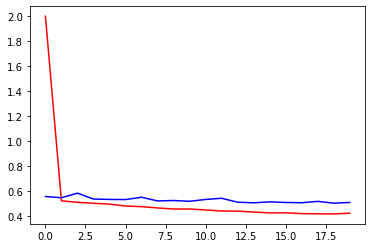

In [109]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'r', val_loss, 'b')

In [85]:
test_data = pd.read_csv("test.csv")
data = test_data['Headline']
label = test_data['Label']
test_split = word_split(data)
sequences = tokenizer.texts_to_sequences(test_split)
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_pre = model.predict(x)
b = np.arange(1, y_pre.shape[0]+1).reshape(y_pre.shape[0], 1)
y_pre = np.append(b, y_pre, axis=1)

In [86]:
import csv
with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID','Label'])
    writer.writerows(y_pre)